In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import datetime
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
sns.set_palette('colorblind')

In [4]:
biden = pd.read_csv("biden_tweets.csv")
trump = pd.read_csv("trump_tweets.csv")
# want to do cluster analysis, based on created_at date and favourites / retweets recieved 
# cluster by morning / day / evening <- created_at represented with military time 

# Data cleaning to create columns used later <- put this in data cleaning section

In [5]:
# create date time column 
biden["date"] = pd.to_datetime(biden["created_at"], format = "%Y-%m-%d %H:%M:%S")
trump["date"] = pd.to_datetime(trump["created_at"], format = "%Y-%m-%d %H:%M:%S")
# create time of day column 
# assign time of day values 
# morning = 5 am : 12 pm = any hour value from 5 to 11 
# afternoon = 12 pm : 5 pm = any hour value from 12 to 16 
# evening = 5 pm : 10 pm = any hour value from 17 to 22 
# night = 10 pm : 5 am = any hour value from 23 to 4 (23,0,1,2,3,4) <- wrap around
def time_of_day (x):
    hour = x.hour 
    if  5 <= hour <= 11: 
        return "morning"
    elif 12 <= hour <= 16:
        return "afternoon"
    elif 17 <= hour <= 22:
        return "evening"
    else:
        return "night"
    
# create column for tweet word count  
def tweet_length (x):
    return len(x.split())
    
# column for hour of day tweet posted 
def hour(x):
    return x.hour 
             
biden['time_of_day'] = biden['date'].map(time_of_day)
biden['tweet_length'] = biden['full_text'].map(tweet_length)
biden['hour'] = biden['date'].map(hour)

trump['time_of_day'] = trump['date'].map(time_of_day)
trump['tweet_length'] = trump['full_text'].map(tweet_length)
trump['hour'] = biden['date'].map(hour)

# create columns that contain series of night vs day where night = 1 , day = 0 
day_night_map = {"morning":0, "afternoon":0, "evening":1, "night":1}
biden['day_or_night'] = biden['time_of_day'].map(day_night_map)
trump['day_or_night'] = trump['time_of_day'].map(day_night_map)
    

# Exploratory Data Analysis for Cluster Analysis 

In [6]:
# show number of tweets at certain times. I found it suprising the large amount of tweets during the night 
print("Biden: ")
print(biden.time_of_day.value_counts()) 
print('\n')
print("Trump: ")
print(trump.time_of_day.value_counts())


Biden: 
evening      1343
night        1196
afternoon     518
morning        27
Name: time_of_day, dtype: int64


Trump: 
night        555
evening      476
afternoon    409
morning      167
Name: time_of_day, dtype: int64


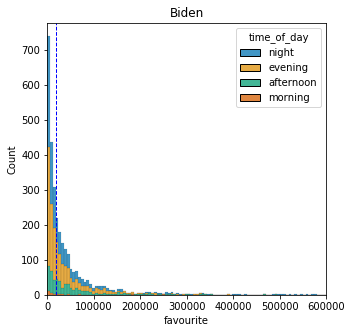

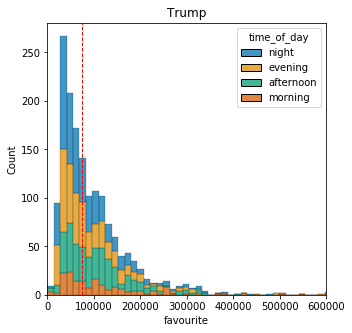

In [7]:
# blue dashed line = biden median value for favorites recieved 
# red dashed line = trump median value for favorites recieved 
plt.figure(figsize = (5,5))
sns.histplot(x="favourite", hue="time_of_day", multiple = "stack", data = biden)
plt.xlim(left = 0, right = 600000)
plt.title("Biden")
plt.axvline(biden['favourite'].median(), color='blue', linestyle='dashed', linewidth=1)

plt.figure(figsize = (5,5))
sns.histplot(x="favourite", hue="time_of_day", multiple = "stack", data = trump)
plt.xlim(left = 0, right = 600000)
plt.title("Trump")
plt.axvline(trump['favourite'].median(), color='red', linestyle='dashed', linewidth=1)


plt.show()

### Tweet Length vs Number of Favorites

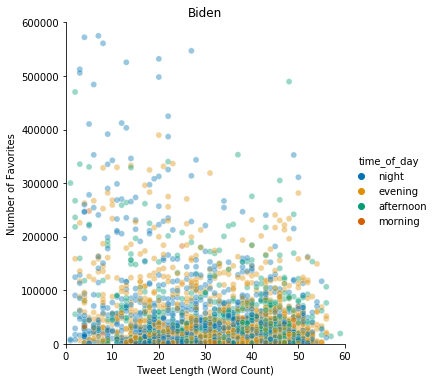

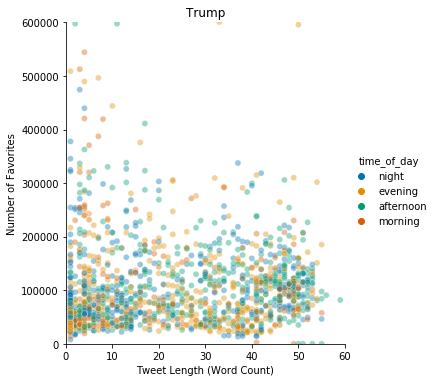

In [8]:
# does not seem to be a relationship between tweet length and number of favorites recieved 
# trump has many tweets that are a single hyperlink to another tweet, which is why he has many tweets of length = 1
sns.relplot(x = "tweet_length", y = "favourite", hue = "time_of_day", alpha = 0.4, data = biden)
plt.xlabel("Tweet Length (Word Count)")
plt.ylabel("Number of Favorites")
plt.title("Biden")
plt.xlim(left = 0, right = 60)
plt.ylim(bottom = 0, top = 600000)

sns.relplot(x = "tweet_length", y = "favourite", hue = "time_of_day", alpha = 0.4, data = trump)
plt.xlabel("Tweet Length (Word Count)")
plt.ylabel("Number of Favorites")
plt.title("Trump")
plt.xlim(left = 0, right = 60)
plt.ylim(bottom = 0, top = 600000)
plt.show()

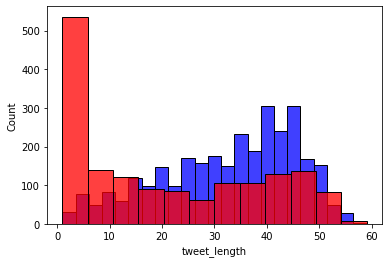

In [9]:
# not included in cluster analysis, possibly do an analysis using tweet length 
sns.histplot(x="tweet_length", color = 'blue', data = biden)
sns.histplot(x="tweet_length", color = 'red',data = trump)
plt.show()

### Research Question: Does the time of day impact tweet behavior? 
#### null hypothesis : time of day does not impact amount of favorites recieved by a tweet <- check for both trump and biden

Biden p value: 4.602892091368418e-168
Trump p vale: 9.077655265894341e-294


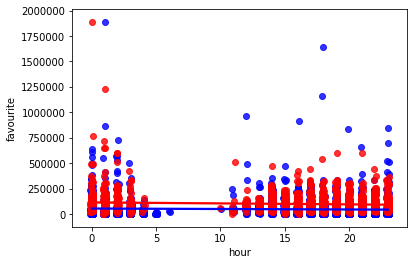

In [10]:
print("Biden p value: {}".format(ttest_ind(biden['favourite'], biden['hour'])[1]))
print("Trump p vale: {}".format(ttest_ind(trump['favourite'], trump['hour'])[1]))
sns.regplot(x='hour', y = 'favourite', color = 'blue',x_jitter = 0.1, data = biden)
sns.regplot(x='hour', y = 'favourite', color = 'red', x_jitter = 0.1, data = trump)
plt.show()

Both t-tests indicate that the null hypothesis should be rejected, and that there is a significant difference in 
the amount of likes recieved during the day (morning and afternoon) versus during the night (evening and night). However, the extremely small p value might not be a strong predictor of the relationship because of the large sample size. The slope in the graph shown above is a horizontal line (~0), which suggests that there is not a linear relationship between time of day (hour) and favorites recieved. 

In [11]:
print("Number of Biden tweets recieving more than 200,000 favourites: {}".format(len(biden[biden['favourite'] > 200000])))
print("Number of Trump tweets recieving more than 200,000 favourites: {}".format(len(trump[trump['favourite'] > 200000])))

Number of Biden tweets recieving more than 200,000 favourites: 137
Number of Trump tweets recieving more than 200,000 favourites: 144


I am deciding to exclude the tweets that recieved more than 200,000 likes in both data sets because these values can greatly skew significance values and regression models. This means that 4.44% of biden data set is not included and 8.96% of trump data set is not included in the analysis.

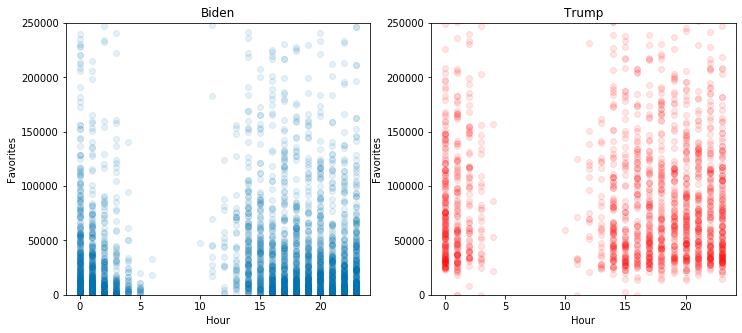

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(biden['hour'],biden['favourite'], alpha = 0.1)
ax1.set_title("Biden")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Favorites")
ax1.set_ylim(top =250000, bottom = 0)

ax2.scatter(trump['hour'],trump['favourite'], color = 'red', alpha = 0.1)
ax2.set_title("Trump")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Favorites")
ax2.set_ylim(top = 250000, bottom = 0)
plt.show()

## Logistic Regression
A heavily liked (favorited) tweet is one that recieves more than 50000 favorites, otherwise it is not heavily liked.

In [13]:
def liked(x):
    if x > 50000:
        return 1 
    else:
        return 0 
biden['loved'] = biden['favourite'].map(liked)
trump['loved'] = trump['favourite'].map(liked)

In [14]:
def logit(x):
    return np.exp(x) / (np.exp(x) + 1)

def log_reg(biden, trump):
    x = 0
    subplot = [121, 122]
    title = ['Biden', 'Trump']
    color = ['blue', 'red']
    df = [biden, trump]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax = [ax1, ax2]
    for i in df: 
        model = LogisticRegression(solver = "lbfgs").fit(i[['hour']], i['loved'])
        x_values = np.linspace(0, 23, 100) 
        ax[x].scatter(i['hour'], i['loved'] + np.random.normal(0, 0.05, size=len(i)), alpha = 0.1, color = color[x])
        ax[x].plot(x_values, logit(x_values * model.coef_[0,0] + model.intercept_[0]), color = color[x])
        ax[x].set_title(title[x])
        ax[x].set_xlabel("hour")
        ax[x].set_ylabel("probability of loved tweet")
        
        x +=1

All data included


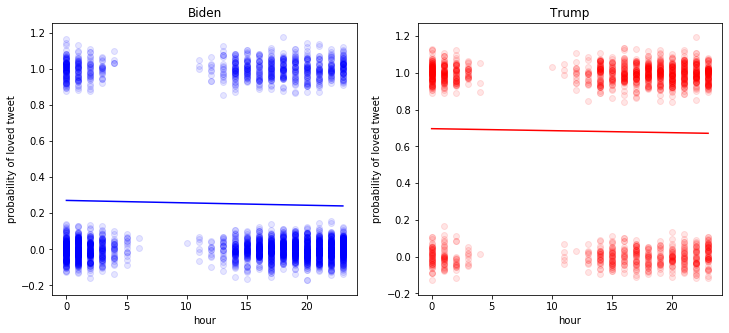

In [15]:
print("All data included")
log_reg(biden, trump)

After filtering out tweets with more than 200000 favorites


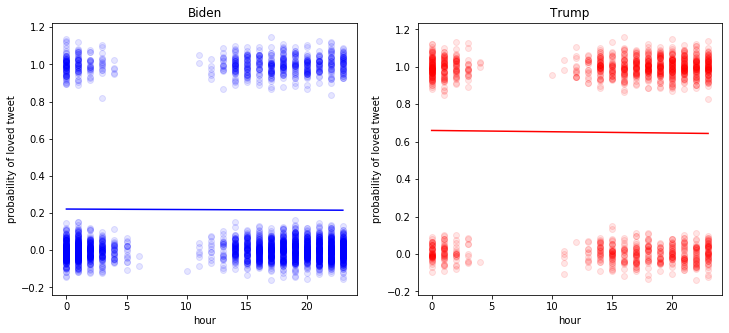

In [16]:
biden_filtered = biden[biden['favourite'] < 200000]
trump_filtered = trump[trump['favourite']< 200000]

print("After filtering out tweets with more than 200000 favorites")
log_reg(biden_filtered, trump_filtered)

From the logistic regression, there does not seem to be a strong correlation between the time a tweet is posted (hour of the day) and the probability of recieving more than 100,000 favorites for that tweet for either Trump or Biden. Additionally, filtering outliers does not seem to impact the results.

### Question for Reviewers
* Would normalization help in any part of this analysis?
* How to fit a binomal regression / fit? I think this could benefit the analysis for time of day vs probability of loved tweet

In [18]:
biden['tweet_length'].sum()

100838